# Starsim learning day - Diseases

This notebook provides an introduction to setting up diseases within Starsim. It is intended to be read in conjunction with the learning day presentation slides available at: https://docs.google.com/presentation/d/1HvIVCP8FKDtuZVmSbCRaITeG2rICCIDggcrBVP0Oe18/edit?usp=sharing. 

Some of these exercises are based closely on the Starsim tutorial on diseases, available at: https://docs.idmod.org/projects/starsim/en/latest/tutorials/tut_diseases.html.

Even though we haven't covered networks yet, many of the diseases that we model transmit over contact networks, so we will include a simple contact network.

Let's start with the example covered in the overview slides from this morning (https://docs.google.com/presentation/d/1hvy3ws8XzvgOj63-juGjOWH2VesqUQ6448mCI4QPxDQ/edit?usp=sharing)

Initializing sim with 10000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.32 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.83 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (1.16 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (1.53 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (1.72 s)  •••••••••••••••••••• 100%



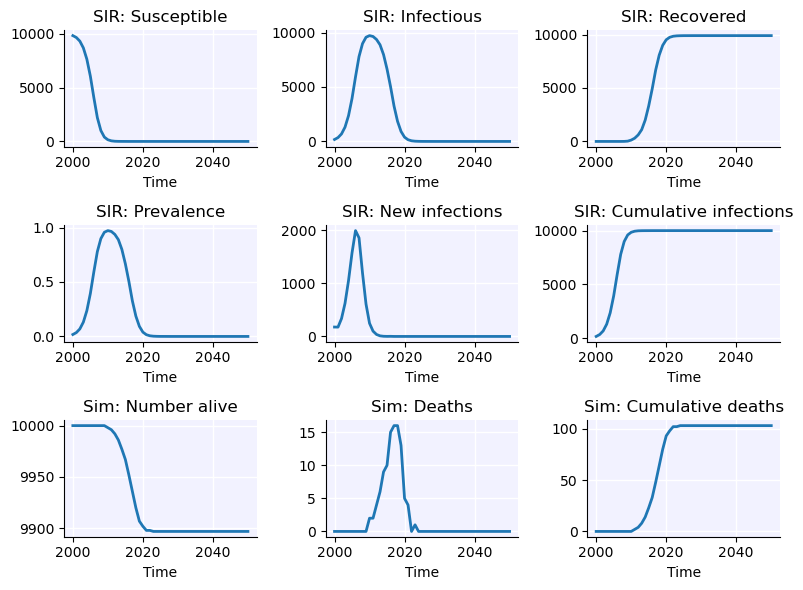

In [4]:
import starsim as ss

pars = dict(
   networks = 'random', # Random network
   diseases = dict(     # The SIR disease model, our focus for this sessoin
       type = 'sir',
       dur_inf = 10,
       beta = 0.1,
   )
)

sim = ss.Sim(pars)
sim.run()
sim.plot()


## Ways of specifying diseases
In the example above, we created a dictionary of parameters (`pars`) and passed this to the simulation (`ss.Sim`). However, it gives us a bit more flexibility if we define the disease as a module and pass that to the sim directly. The example above is equivalent to the example below:

In [5]:
sir = ss.SIR(beta=0.1, dur_inf=10)
network = ss.RandomNet()
sim = ss.Sim(diseases=sir, networks=network)

## Customizing the SIR model
The easiest way to customize the model is by changing the parameters. For example:

In [ ]:
sir_10years = ss.SIR(beta=0.1, dur_inf=10, label='sir')
sir_20years = ss.SIR(beta=0.1, dur_inf=20, label='sir')
sim_10years = ss.Sim(diseases=sir_10years, networks=network, label='10 years')
sim_20years = ss.Sim(diseases=sir_20years, networks=network, label='20 years')
sim_10years.run()
sim_20years.run()

We can plot the two sims to see the differences:

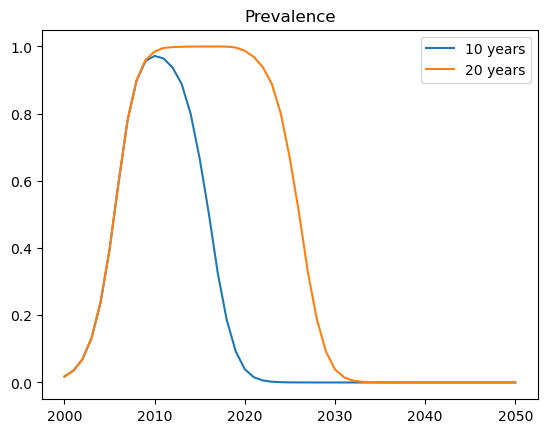

In [19]:
import pylab as pl
def plot_sims(*sims):
    pl.figure()
    for sim in sims:
        pl.plot(sim.results.timevec, sim.results.sir.prevalence, label=sim.label)
    pl.title('Prevalence')
    pl.legend()
    pl.show();
    
plot_sims(sim_10years, sim_20years)

### Changing the timescale
By default, the timestep for Starsim is 1 year. However, if you want to change this for your disease so it's in days instead of years, this can be done as follows:

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.00 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.34 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.53 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.69 s)  •••••••••••••••••••• 100%



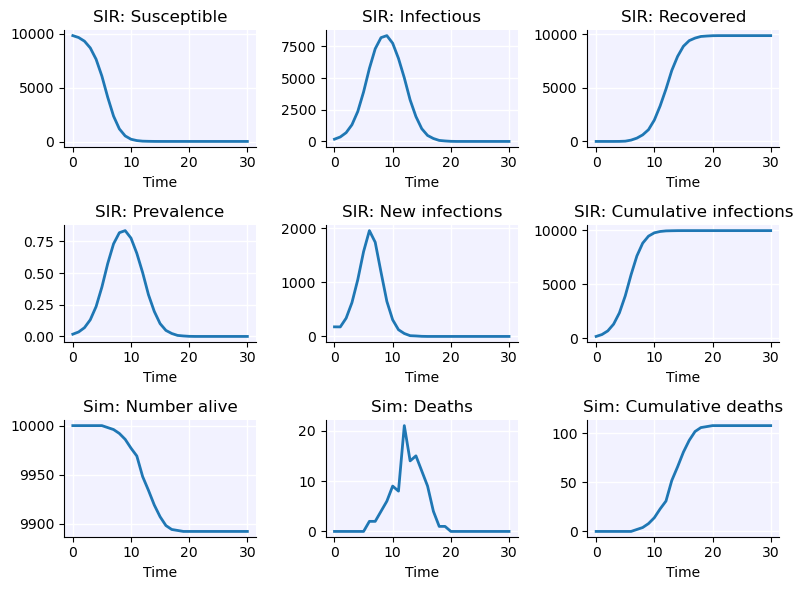

In [27]:
sir = ss.SIR(beta=ss.beta(0.1), dur_inf=ss.dur(10, 'days'))
# Simulate from 2020 for 1 month with a daily timestep
sim = ss.Sim(
    start=0,
    dur=30,
    unit='day',      
    diseases=sir,
    networks=network
)
sim.run()
sim.plot()

### Introducing variability
Rather than defining our model so that everyone is infected for 10 days, we can set it up so that the duration of infection is randomly distributed.

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.00 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.47 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.69 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.99 s)  •••••••••••••••••••• 100%



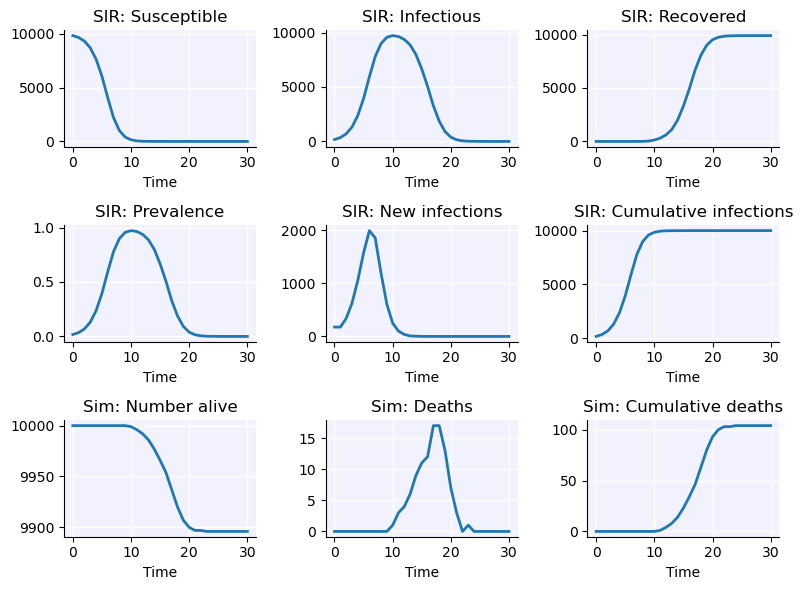

In [28]:
sir = ss.SIR(
    beta=ss.beta(0.1),
    dur_inf=ss.dur(ss.normal(loc=10, scale=1), 'day')
)
# Simulate from 2020 for 1 month with a daily timestep
sim = ss.Sim(
    start=0,
    dur=30,
    unit='day',      
    diseases=sir,
    networks=network
)
sim.run()
sim.plot()

## Other types of model
The default Starsim package includes a few different archtypes of diseases (SIR, SEIR, SIS), as well as a few examples of specific diseases (Ebola, measles, cholera... ). You can experiment with any of the examples in the same way that we have with the SIR model, by changing parameters. Often this is a gateway to the model calibration process, where you will typically adjust model parameters like we did in the first example with `dur_inf` to match surveillance data that you might have.

Getting familiar with the standard library of models is also the best pathway for learning how to create your own disease module. If you're interested in doing this, we have an advanced tutorial (https://docs.idmod.org/projects/starsim/en/latest/tutorials/dev_tut_diseases.html), and you may also like to look through some of our other repositories like STIsim (https://github.com/starsimhub/stisim) for inspiration on disease structure.

## Modeling multiple diseases together
Co-transmission modeling is one of Starsim's main selling points! Starsim has been specifically designed to make it simple and fast to model multiple diseases.

To add more that one disease, you can just pass the simulation a list of diseases rather than a single disease: